### ATENÇÃO:
    Para poder executer este notebook apropriadamente é necessário ter instalado a biblioteca sklearn_lvq em sua máquina
    
    Basta executar pip install sklearn-lvq que a biblioteca já sera instalada

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, accuracy_score

# Models
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn_lvq import GlvqModel as lvq
import seaborn as sns

Definindo procedimentos auxiliares

In [ ]:
def get_categorical_data_encoding(X, encoding='one-hot', categorical_attrs=None):
    X_encoded = None
    if encoding=='one-hot':
        X_encoded = pd.get_dummies(X)
    elif encoding == 'label':
        if not isinstance(categorical_attrs, list): 
            raise Exception('A list of attributes is expected')        
        X_encoded = X.copy()
        for cat_attr in categorical_attrs: 
            X_encoded[cat_attr] = X[cat_attr].astype('category').cat.codes
    else: 
        raise Exception('Undefined encoding type')
    return X_encoded

def get_scaler(scaling_option='min-max'):
    scaler = None
    if scaling_option == 'min-max':
        scaler = MinMaxScaler()
    elif scaling_option == 'standard':
        scaler = StandardScaler()
    else:
        raise Exception('Undefined Scaler type')
    return scaler


def plot_confution_matrix(Y_predicted, Y_expected, ax=None):
    cm = metrics.confusion_matrix(Y_predicted, Y_expected)
    cm_dis = metrics.ConfusionMatrixDisplay(cm).plot(ax=ax)

    
def plot_roc_curve(Y_predicted, Y_expected, ax=None):
    fpr, tpr, _ = metrics.roc_curve(Y_predicted, Y_expected)
    metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax)
    
def plot_precision_recall(Y_predicted, Y_expected, ax=None):
    precision, recall, _ = metrics.precision_recall_curve(Y_predicted, Y_expected)
    metrics.PrecisionRecallDisplay(precision=precision, recall=recall).plot(ax=ax)
    
def plot_results(Y_predicted, Y_expected):
    
    if len(Y_predicted.shape) > 1:
        Y_predicted = Y_predicted.argmax(axis=1)
        Y_expected  = Y_expected.values.argmax(axis=1)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, dpi=100, figsize=(10,2));

    #cm = metrics.confusion_matrix(Y_predicted, Y_expected)
    #cm_dis = metrics.ConfusionMatrixDisplay(cm).plot(ax=ax1)
    plot_confution_matrix(Y_predicted, Y_expected, ax=ax1)

    #fpr, tpr, _ = metrics.roc_curve(Y_predicted, Y_expected)
    #metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax2)
    plot_roc_curve(Y_predicted, Y_expected, ax=ax2)

    #precision, recall, _ = metrics.precision_recall_curve(Y_predicted, Y_expected)
    #metrics.PrecisionRecallDisplay(precision=precision, recall=recall).plot(ax=ax3)
    plot_precision_recall(Y_predicted, Y_expected, ax=ax3)

    plt.subplots_adjust(wspace=0.9, hspace=1.5)

In [ ]:
def transfer_atributes_to_new_dataframe(transformed_dataset, dataset, attributes_list):
    for col in attributes_list:
        transformed_dataset[col] = dataset[col]
    return transformed_dataset

def replace_missing_values_with_mean(transformed_dataset, dataset, attributes_list):
    for col in attributes_list:
        a_nm = dataset[dataset[col].notnull()==True][col]
        transformed_dataset[col] = dataset[col].replace(np.nan, a_nm.mode()[0])
    return transformed_dataset

def replace_missing_values_with_mode(transformed_dataset, dataset, attributes_list):
    for col in attributes_list:
        a_nm = dataset[dataset[col].notnull()==True][col]
        transformed_dataset[col] = dataset[col].replace(np.nan, a_nm.mode()[0])        
    return transformed_dataset

def clean_data(dataset):
    transformed_dataset = pd.DataFrame()
    
    transformed_dataset = replace_missing_values_with_mode(transformed_dataset, dataset, ['A1'])

    # Getting a1 non missing Values
    transformed_dataset = replace_missing_values_with_mean(transformed_dataset, dataset, ['A2'])

    # Getting A3 index
    transformed_dataset = transfer_atributes_to_new_dataframe(transformed_dataset, dataset, ['A3'])

    transformed_dataset = replace_missing_values_with_mode(transformed_dataset, dataset, ['A4','A5','A6', 'A7'])


    transformed_dataset = transfer_atributes_to_new_dataframe(transformed_dataset, dataset, ['A8','A9','A10', 
                                                                                          'A11', 'A12', 'A13'])

    transformed_dataset = replace_missing_values_with_mean(transformed_dataset, dataset, ['A14'])


    transformed_dataset = transfer_atributes_to_new_dataframe(transformed_dataset, dataset, ['A15'])
    
    return transformed_dataset


## Processamento de Dados

In [ ]:
cols = ['A'+str(n) for n in range(1,17)]
dataset = pd.read_csv('crx.data', header=None, na_values='?')
dataset.columns = cols

In [ ]:
dataset.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,280.0,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,+


Descrição dos tipos de dados de cada atributo

In [ ]:
dataset.dtypes

A1      object
A2     float64
A3     float64
A4      object
A5      object
A6      object
A7      object
A8     float64
A9      object
A10     object
A11      int64
A12     object
A13     object
A14    float64
A15      int64
A16     object
dtype: object

Percentual de dados faltantes por atributo

In [ ]:
(dataset.isnull().sum() / dataset.shape[0]) * 100

A1     1.739130
A2     1.739130
A3     0.000000
A4     0.869565
A5     0.869565
A6     1.304348
A7     1.304348
A8     0.000000
A9     0.000000
A10    0.000000
A11    0.000000
A12    0.000000
A13    0.000000
A14    1.884058
A15    0.000000
A16    0.000000
dtype: float64

## One Hot categorical data

Separando atributos de classe dos outros atributos

In [ ]:
Y = dataset['A16']
X = dataset.drop(['A16'], axis=1)

Codificação OneHot

In [ ]:
X_one_hot = pd.get_dummies(X)
X_one_hot.isnull().sum()

A2       12
A3        0
A8        0
A11       0
A14      13
A15       0
A1_a      0
A1_b      0
A4_l      0
A4_u      0
A4_y      0
A5_g      0
A5_gg     0
A5_p      0
A6_aa     0
A6_c      0
A6_cc     0
A6_d      0
A6_e      0
A6_ff     0
A6_i      0
A6_j      0
A6_k      0
A6_m      0
A6_q      0
A6_r      0
A6_w      0
A6_x      0
A7_bb     0
A7_dd     0
A7_ff     0
A7_h      0
A7_j      0
A7_n      0
A7_o      0
A7_v      0
A7_z      0
A9_f      0
A9_t      0
A10_f     0
A10_t     0
A12_f     0
A12_t     0
A13_g     0
A13_p     0
A13_s     0
dtype: int64

In [ ]:
X_one_hot.dtypes

A2       float64
A3       float64
A8       float64
A11        int64
A14      float64
A15        int64
A1_a       uint8
A1_b       uint8
A4_l       uint8
A4_u       uint8
A4_y       uint8
A5_g       uint8
A5_gg      uint8
A5_p       uint8
A6_aa      uint8
A6_c       uint8
A6_cc      uint8
A6_d       uint8
A6_e       uint8
A6_ff      uint8
A6_i       uint8
A6_j       uint8
A6_k       uint8
A6_m       uint8
A6_q       uint8
A6_r       uint8
A6_w       uint8
A6_x       uint8
A7_bb      uint8
A7_dd      uint8
A7_ff      uint8
A7_h       uint8
A7_j       uint8
A7_n       uint8
A7_o       uint8
A7_v       uint8
A7_z       uint8
A9_f       uint8
A9_t       uint8
A10_f      uint8
A10_t      uint8
A12_f      uint8
A12_t      uint8
A13_g      uint8
A13_p      uint8
A13_s      uint8
dtype: object

In [ ]:
# Separando conjunto de treino e conjunto de testes/validação
X_one_hot_train, X_one_hot_val, Y_one_hot_train, Y_one_hot_val = train_test_split(X_one_hot, Y, 
                                                                                  test_size=.3, random_state=1)

# Tratando dados faltantes do atributos
X_one_hot_train['A2'] = X_one_hot_train.copy()['A2'].replace(np.nan, X_one_hot_train['A2'].mean())
X_one_hot_val['A2'] = X_one_hot_val.copy()['A2'].replace(np.nan, X_one_hot_val['A2'].mean())

X_one_hot_train['A14'] = X_one_hot_train.copy()['A14'].replace(np.nan, X_one_hot_train['A14'].mean())
X_one_hot_val['A14'] = X_one_hot_val.copy()['A14'].replace(np.nan, X_one_hot_val['A14'].mean())

<ipython-input-11-ad66b79d8e8d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_one_hot_train['A2'] = X_one_hot_train.copy()['A2'].replace(np.nan, X_one_hot_train['A2'].mean())
<ipython-input-11-ad66b79d8e8d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_one_hot_val['A2'] = X_one_hot_val.copy()['A2'].replace(np.nan, X_one_hot_val['A2'].mean())
<ipython-input-11-ad66b79d8e8d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

## Label Encoding Categorical Data

In [ ]:
# Separando conjunto de treino e conjunto de testes/validação
X_le_train, X_le_val, Y_le_train, Y_le_val = train_test_split(X, Y, test_size=.3, random_state=1)

X_le_train = clean_data(X_le_train)
X_le_val = clean_data(X_le_val)

X_le_train = get_categorical_data_encoding(X_le_train, encoding='label', 
                                           categorical_attrs=['A1', 'A4', 'A5', 'A6', 'A7',
                                                              'A9', 'A10', 'A12', 'A13'])

X_le_val = get_categorical_data_encoding(X_le_val, encoding='label', 
                                         categorical_attrs=['A1', 'A4', 'A5', 'A6', 'A7', 
                                                            'A9', 'A10', 'A12', 'A13'])

# MODELING

## KNN

Definindo procedimento auxiliar para executar KNN

In [ ]:
def run_knn(X_train, Y_train, X_val, Y_val, scaling='min-max', n_neighbors=3, 
            metric='euclidean'):
    knn_classifier = knn(n_neighbors, metric=metric)
    
    Y_train = pd.get_dummies(Y_train)
    Y_val = pd.get_dummies(Y_val)
    
    scaler = get_scaler(scaling_option=scaling)    
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.fit_transform(X_val)
       
    knn_classifier.fit(X_train_scaled, Y_train)
    
    return  knn_classifier.predict(X_val_scaled), Y_val

## LVQ 

Definindo procedimento auxiliar para executar o LVQ

OBS: _devido a limitações na biblioteca importada neste notebook foi necessário utilizar label encoding nos atributos de classe_

In [ ]:
def run_lvq(X_train_lvq, Y_train_lvq, X_val_lvq, Y_val_lvq, scaling='min-max',
            n_prototypes_per_class=3, max_iter=1000):
        
    Y_train_lvq = Y_train_lvq.astype('category').cat.codes
    Y_val_lvq = Y_val_lvq.astype('category').cat.codes
    
    scaler = get_scaler(scaling_option=scaling)
    
    X_train_lvq = scaler.fit_transform(X_train_lvq)
    X_val_lvq = scaler.fit_transform(X_val_lvq)
    
    lvq_model = lvq(prototypes_per_class=n_prototypes_per_class, max_iter=max_iter)
    lvq_model.fit(X_train_lvq, Y_train_lvq)
    
    return lvq_model.predict(X_val_lvq), Y_val_lvq
    

## Comparando Algoritmos

O algoritmo KNN foi executado utilizando dados categóricos condificados com one hot encoding e label encoding. Também foram testadas opções de pré-processamento, mais especificamente os métodos MinMax e a padronização, também chamada de standard scaler. As mesmas variações foram aplicadas para o algoritmo LVQ. 

As comparações foram feitas usando o conjunto de validação

### Executando KNN

Para o algoritmo KNN foram executados considerando numero de vizinhos $n=3$ e $n=5$. Como pode ser observado a partir dos resultados ao se utilizar KNN com scaling "min-max" e 5 vizinhos com valores categóricos codificados utilizando label encoding foi quando o algoritmo apresentou bons resultados de acurácia. 

Porém também pode-se observer que houveram variações dos experimentos aos quais apresentaram bons resultados levando em conta a precisão (Precision) e a cobertura (Recall)

### Executando KNN com dados categóricos com codificação One-Hot

Accuracy:  0.8985507246376812


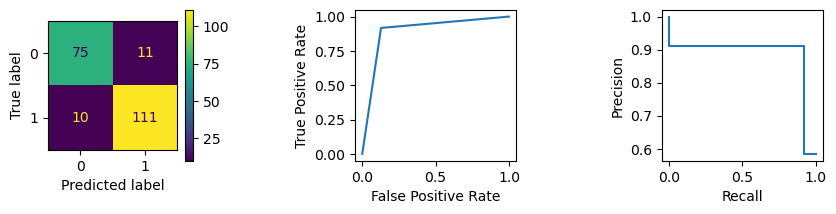

In [ ]:
Y_preds, Y_expected = run_knn(X_one_hot_train, Y_one_hot_train, 
                              X_one_hot_val, Y_one_hot_val, scaling='min-max', n_neighbors=5)

plot_results(Y_preds, Y_expected)
print('Accuracy: ',metrics.accuracy_score(Y_preds, Y_expected))

Executando algoritmo com min max Scaler e usando Label Encoding e 3 vizinhos

Accuracy:  0.8695652173913043


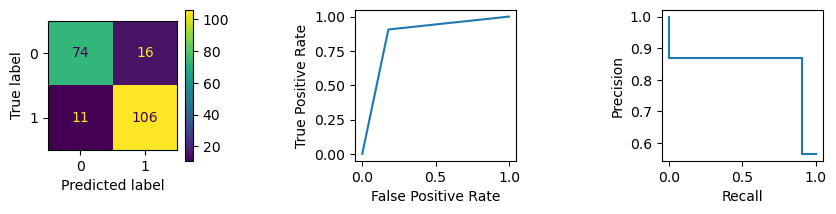

In [ ]:
Y_preds, Y_expected = run_knn(X_one_hot_train, Y_one_hot_train, 
                              X_one_hot_val, Y_one_hot_val, scaling='min-max', n_neighbors=3)

plot_results(Y_preds, Y_expected)
print('Accuracy: ',metrics.accuracy_score(Y_preds, Y_expected))

### Executando KNN com dados categóricos com codificação Label Encoding

Accuracy:  0.8888888888888888


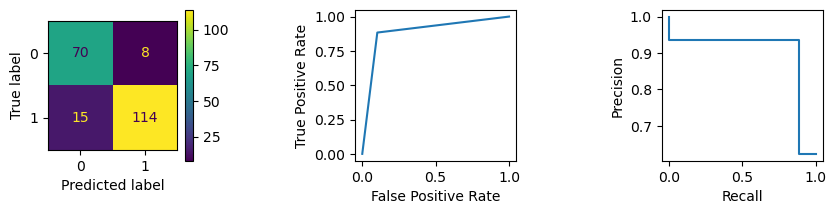

In [ ]:
Y_preds, Y_expected = run_knn(X_le_train, Y_le_train, 
                              X_le_val, Y_le_val, scaling='standard', n_neighbors=3)
plot_results(Y_preds, Y_expected)
print('Accuracy: ',metrics.accuracy_score(Y_preds, Y_expected))

### Executando KNN com Dados categóricos usando Label Encoding

Accuracy:  0.9130434782608695


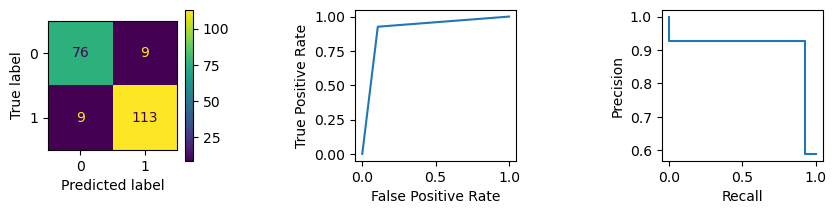

In [ ]:
Y_preds, Y_expected = run_knn(X_le_train, Y_le_train, 
                              X_le_val, Y_le_val, scaling='min-max', n_neighbors=5)
plot_results(Y_preds, Y_expected)
print('Accuracy: ',metrics.accuracy_score(Y_preds, Y_expected))

Executando algoritmo com Standard Scaler e 5 vizinhos

Accuracy:  0.8985507246376812


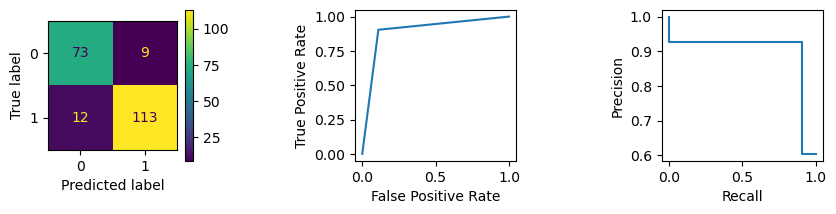

In [ ]:
Y_preds, Y_expected = run_knn(X_le_train, Y_le_train, 
                              X_le_val, Y_le_val, scaling='standard', n_neighbors=5)
plot_results(Y_preds, Y_expected)
print('Accuracy: ',metrics.accuracy_score(Y_preds, Y_expected))

### Executando LVQ

Considerando o algoritmo LVQ, a variação que resultou em melhor valor de acurácia também foi uma variação utilizando label encoding. Com aproximadamente $90\%$ de acurácia, o algoritmo foi definido utilizando apenas $1$ protótipo por classe, os dados foram preprocessados utilizando standard scaller e um número máximo de interações de $2000$ ao ser executado. 

Contudo, pode-se observar outras variações que apresentaram acurácias ligeiramente piores porém com resultados rasoáveis considerando a cobertura e a precisão dos algoritmos. 

### Executando LVQ com dados categóricos com codificação One-Hot

Accuracy:  0.893719806763285


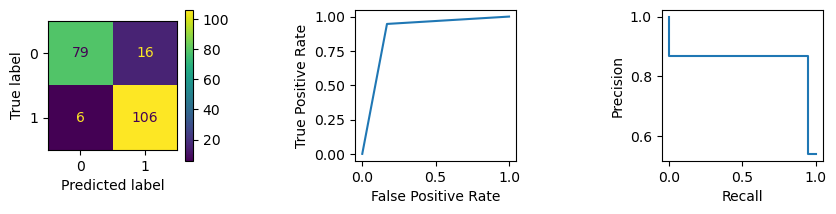

In [ ]:
Y_predicted, Y_expected = run_lvq(X_one_hot_train, Y_one_hot_train, 
                                  X_one_hot_val, Y_one_hot_val, scaling='min-max',
                                  n_prototypes_per_class=5, max_iter=2000)
plot_results(Y_predicted, Y_expected)
print('Accuracy: ',metrics.accuracy_score(Y_predicted, Y_expected))

Accuracy:  0.9082125603864735


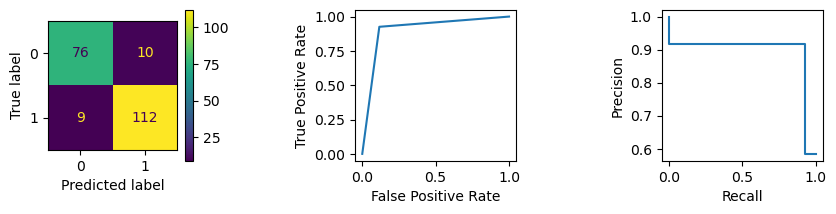

In [ ]:
Y_predicted, Y_expected = run_lvq(X_one_hot_train, Y_one_hot_train, 
                                  X_one_hot_val, Y_one_hot_val, scaling='standard',
                                  n_prototypes_per_class=2, max_iter=2000)
plot_results(Y_predicted, Y_expected)
print('Accuracy: ',metrics.accuracy_score(Y_predicted, Y_expected))

### Executando LVQ com dados categóricos com codificação Label Encoding

Accuracy:  0.8743961352657005


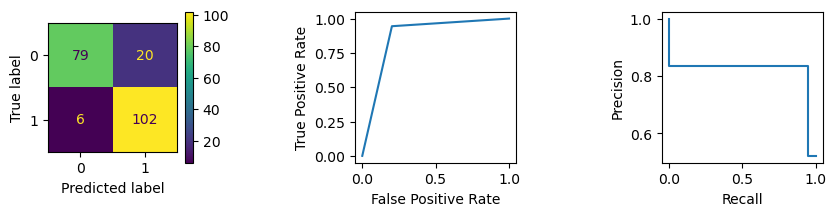

In [ ]:
Y_predicted, Y_expected = run_lvq(X_le_train, Y_le_train, 
                                  X_le_val, Y_le_val, scaling='min-max',
                                  n_prototypes_per_class=5, max_iter=2000)
plot_results(Y_predicted, Y_expected)
print('Accuracy: ',metrics.accuracy_score(Y_predicted, Y_expected))

Accuracy:  0.9033816425120773


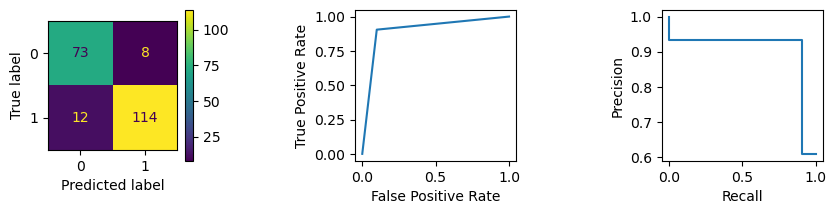

In [ ]:
Y_predicted, Y_expected = run_lvq(X_le_train, Y_le_train, 
                                  X_le_val, Y_le_val, scaling='standard',
                                  n_prototypes_per_class=5, max_iter=2000)
plot_results(Y_predicted, Y_expected)
print('Accuracy: ',metrics.accuracy_score(Y_predicted, Y_expected))

Accuracy:  0.9033816425120773


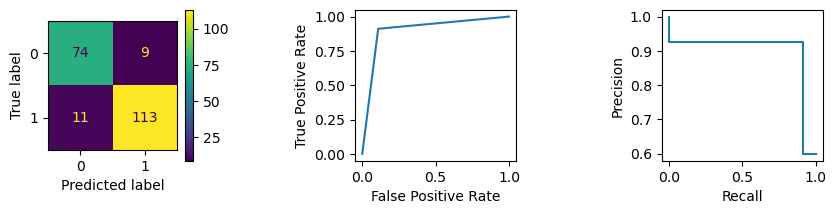

In [ ]:
Y_predicted, Y_expected = run_lvq(X_le_train, Y_le_train, 
                                  X_le_val, Y_le_val, scaling='standard',
                                  n_prototypes_per_class=1, max_iter=2000)
plot_results(Y_predicted, Y_expected)
print('Accuracy: ',metrics.accuracy_score(Y_predicted, Y_expected))

## Comparando Variações com melhores Acurácias

Mesmo com uma ligeira diferença na acurácia ambas variações apresentam desempenho semelhante

In [ ]:
Y_lvq_predicted, Y_lvq_expected = run_lvq(X_le_train, Y_le_train, 
                                          X_le_val, Y_le_val, scaling='standard',
                                          n_prototypes_per_class=1, max_iter=2000)

Y_knn_predicted, Y_knn_expected = run_knn(X_le_train, Y_le_train, 
                                          X_le_val, Y_le_val, scaling='min-max', n_neighbors=5)

Accuracy KNN:  0.9130434782608695 	 Accuracy LVQ:  0.9033816425120773


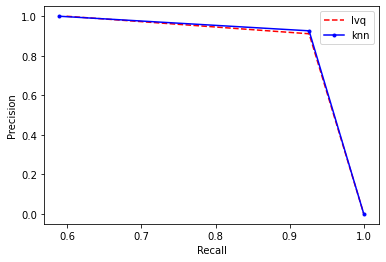

In [ ]:
print('Accuracy KNN: ', metrics.accuracy_score(Y_knn_predicted, Y_knn_expected), '\t',
      'Accuracy LVQ: ', metrics.accuracy_score(Y_lvq_predicted, Y_lvq_expected))
prec_lvq, rec_lvq, _ = metrics.precision_recall_curve(Y_lvq_predicted, Y_lvq_expected)
prec_knn, rec_knn, _ = metrics.precision_recall_curve(Y_knn_predicted.argmax(axis=1), 
                                                      Y_knn_expected.values.argmax(axis=1))

plt.plot(prec_lvq, rec_lvq, 'r--', label='lvq')
plt.plot(prec_knn, rec_knn, 'b.-', label='knn')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend()
plt.show()

In [ ]:
print('Accuracy KNN - Accuracy LVQ ', np.abs(metrics.accuracy_score(Y_knn_predicted, Y_knn_expected) - metrics.accuracy_score(Y_lvq_predicted, Y_lvq_expected)))

Accuracy KNN - Accuracy LVQ  0.009661835748792202
